<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/From%20Colab/Combined3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4213      0 --:--:-- --:--:-- --:--:--  4213
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 36 kB/s 
     |████████████████████████████████| 1.0 MB 59.5 MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

In [ ]:
#@title
###Test: Judy's new X code
#N_STOCKS = 3

In [ ]:
#@title
#X = cupy.array([])
#for i in range(0,N_STOCKS):
  #X =  cupy.concatenate((X,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
#X = X.reshape(N_STOCKS,6)
#X

array([[1.        , 1.        , 0.05103263, 0.0071633 , 0.52167781,
        1.        ],
       [1.        , 1.        , 0.64857557, 0.32324551, 0.39745689,
        1.        ],
       [1.        , 1.        , 0.82301291, 0.46666519, 0.8391176 ,
        1.        ]])

In [ ]:
#@title
#X = X * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6))
#X

array([[2.00000000e+02, 0.00000000e+00, 1.02065252e+01, 2.86532070e-03,
        1.04335564e-01, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 1.29715113e+02, 1.29298207e-01,
        7.94913799e-02, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 1.64602581e+02, 1.86666078e-01,
        1.67823523e-01, 2.00000003e-01]])

# TEST_ERIN

In [3]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        tmp1 = mu[batch_id]*T/N_STEPS
        tmp2 = math.exp(-r[batch_id]*T)
        running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
            s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
            running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
            if i==0 and batch_id == 2:
                print(s_curr)
            if running_average <= B[batch_id]: # if reach barrier, drop out the path
                break
        payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        d_s[i] = tmp2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        for op in range(self.N_BATCH):
          #[K,B,S0,sigma,mu,r]
          X = cupy.array([])
          K_rand = cupy.random.rand(1)[0]
          B_rand = cupy.random.rand(1)[0]
          r_rand = cupy.random.rand(1)[0]
          for i in range(0,self.N_STOCKS):
            X =  cupy.concatenate((X,cupy.array([K_rand,B_rand]), cupy.random.rand(3),cupy.array([r_rand])))
          X = X.reshape(self.N_STOCKS,6)
          X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
          #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
          # scale the [0, 1) random numbers to the correct range for each of the option parameters
          #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

          # make sure the Barrier is smaller than the Strike price
          # X[:, 1] = X[:, 0] * X[:, 1]
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:]

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

          #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
          #cupy.fill_diagonal(stocks_randoms_cov, rho)

          #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
          stocks_randoms_cov = cupy.array([1] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)
          cupy.fill_diagonal(stocks_randoms_cov, 1)

          num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
          randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
                                                        num_of_randoms_each_stock, dtype=cupy.float32)
          b1_r = randoms_gpu[:,0]
          b2_r = randoms_gpu[:,1]
          randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
          for i in range(interval):
            if i % 2 == 0:
                ind = int(i/2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
            else:
                ind = int(i//2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

          randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
          Y[op] = o.mean(axis = 0).mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# for i in ds:
#     print(i[0])
################################# TEST ########################################

Writing cupy_dataset.py


### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

### Modified Model

In [4]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(18, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        # self.register_buffer('norm',
        #                      torch.tensor([200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
        #                                    200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
        #                                    200.0, 198.0, 200.0, 0.4, 0.2, 0.2])) # don't use numpy here - will give error later
        self.register_buffer('norm',
                             torch.tensor([200.0, 0.1, 200.0, 0.4, 0.2, 0.2]*3)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 221 kB 4.4 MB/s 


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
dataset = NumbaOptionDataSet(max_len=100, number_path = 1024, batch=32, stocks=3)

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=100)

loss 1348.211181640625 average time 0.16685850134999783
loss 1128.984375 average time 0.08487756330000593
loss 940.9929809570312 average time 0.057521459633339114
loss 125.07563781738281 average time 0.04385662178750636
loss 72.34493255615234 average time 0.035652158290006356
loss 76.38220977783203 average time 0.030184201966676483
loss 27.641807556152344 average time 0.026275256678578832
loss 31.383182525634766 average time 0.02334492896875844
loss 23.642253875732422 average time 0.021068233811120586
loss 24.765731811523438 average time 0.019250153810008896
loss 27.127243041992188 average time 0.017756466418185565
loss 27.962196350097656 average time 0.016511562258339534
loss 30.81705665588379 average time 0.015457891973077354


Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

$2365$ seconds The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
model_save_name = 'checkpoint11.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
model_save_name = 'checkpoint9.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [9]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=18, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


**Continue to train model**

In [14]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
dataset = NumbaOptionDataSet(max_len=500, number_path = 1024, batch=32, stocks=3)

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=10)

model_save_name = 'checkpoint11.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.48370611667633057 average time 0.024869940649955423 iter num 20
loss 0.23659902811050415 average time 0.014064888874952431 iter num 40
loss 0.13898353278636932 average time 0.010370978116642011 iter num 60
loss 0.15381325781345367 average time 0.00852928206248862 iter num 80
loss 0.10522627830505371 average time 0.0074478765199910415 iter num 100
loss 0.17338532209396362 average time 0.006697822249998353 iter num 120
loss 0.1016591340303421 average time 0.00615368581428746 iter num 140
loss 0.15757668018341064 average time 0.005753018912508878 iter num 160
loss 0.1453799605369568 average time 0.005467634561124315 iter num 180
loss 0.30805620551109314 average time 0.0052077260150076654 iter num 200
loss 0.15706555545330048 average time 0.005014386427278209 iter num 220
loss 0.20118647813796997 average time 0.004853936387498455 iter num 240
loss 0.1733078807592392 average time 0.004713373911536459 iter num 260
loss 0.19088438153266907 average time 0.004590169503569541 iter num 280

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

### Inference and Greeks

We can load the model parameters and use it to do inference

In [11]:
import torch
inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*3]).cuda()
model(inputs.float())

tensor([[11.9587]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [12]:
inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*3]).cuda()
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[ -0.1568,  -5.7866,   0.2037,   8.3948,  10.7799, -16.1402,  -0.1797,
         -26.8531,   0.1989,   8.3515,  11.7578,  -2.4725,  -0.1813,  31.8314,
           0.2219,   9.2660,  12.2200,   7.6163]], device='cuda:0')

Here we are going to plot the Delta graph:-

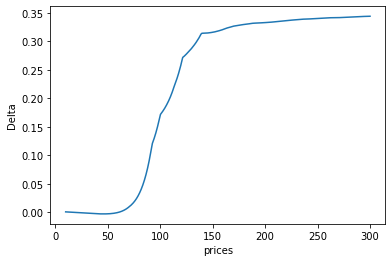

In [13]:
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 300, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [14]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*3]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-1.4180e-03, -2.0633e-01,  4.0882e-03, -1.0803e-01,  3.5117e-01,
          -3.2388e-01, -1.4516e-03, -3.2864e-01,  2.3022e-04,  6.0619e-03,
           3.8800e-02,  7.9051e-02, -1.4529e-03,  4.3756e-01,  7.8982e-05,
           9.8479e-03,  3.1283e-03,  8.0015e-03]], device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

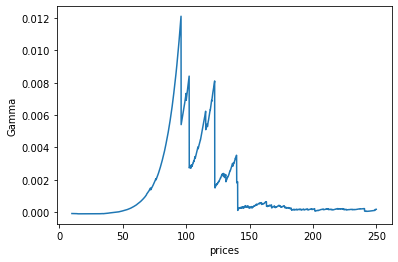

In [15]:
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(10, 250, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

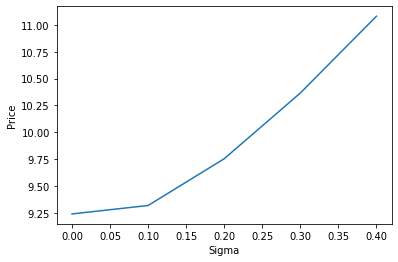

In [ ]:
import pylab
import numpy as np
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 0.0, 110.0, sigma, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    x = model(inputs.float())
    #x = model(inputs)
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
def bisection_root(small, large, fun, target, EPS=1e-6):
    if fun(large) - target < 0:
        print('upper bound is too small')
        return None
    if fun(small) - target > 0:
        print('lower bound is too large')
        return None
    while large - small > EPS:
        mid = (large + small) / 2.0
        if fun(mid) - target >= 0:
            large = mid
        else:
            small = mid
    mid = (large + small) / 2.0
    return mid, abs(fun(mid) - target)
quoted_price = 16.0
sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
print('implied volativity', sigma, 'error', err)     

upper bound is too small


TypeError: ignored